In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.cluster import KMeans

# --- 1. Encoder Module (from TS-TCC) ---
class TSEncoder(nn.Module):
    def __init__(self, input_dims, output_dims, hidden_dims=64, depth=3):
        super(TSEncoder, self).__init__()
        layers = []
        current_in = input_dims
        for _ in range(depth):
            layers.extend([
                nn.Conv1d(current_in, hidden_dims, kernel_size=3, padding=1),
                nn.BatchNorm1d(hidden_dims),
                nn.ReLU()
            ])
            current_in = hidden_dims
        layers.append(nn.Conv1d(hidden_dims, output_dims, kernel_size=1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x: [batch, seq_len, input_dims]
        x = x.permute(0, 2, 1)  # to [batch, input_dims, seq_len]
        out = self.network(x)
        return out.permute(0, 2, 1)  # to [batch, seq_len, output_dims]


# --- 2. Hybrid MEMTO-TSTCC Model ---
class MEMTO_TSTCC(nn.Module):
    def __init__(self, input_dim, latent_dim, num_memory_items, n_heads=4, n_layers=2):
        super(MEMTO_TSTCC, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder from TS-TCC
        self.encoder = TSEncoder(input_dims=input_dim, output_dims=latent_dim)
        
        # --- Modules for TS-TCC Loss ---
        tstcc_encoder_layers = nn.TransformerEncoderLayer(
            d_model=latent_dim, nhead=n_heads, dim_feedforward=latent_dim * 2,
            dropout=0.1, batch_first=True, norm_first=True
        )
        self.temporal_transformer = nn.TransformerEncoder(tstcc_encoder_layers, num_layers=n_layers)
        self.temporal_predictor = nn.Linear(latent_dim, latent_dim)
        self.projector = nn.Sequential(
            nn.Linear(latent_dim, latent_dim), nn.ReLU(), nn.Linear(latent_dim, latent_dim)
        )

        # --- Modules for MEMTO Logic ---
        self.memory = nn.Parameter(torch.randn(num_memory_items, latent_dim), requires_grad=True)
        self.U_psi = nn.Linear(latent_dim, latent_dim)
        self.W_psi = nn.Linear(latent_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim), nn.ReLU(), nn.Linear(latent_dim, input_dim)
        )

    def forward(self, x_primary, x_secondary=None, phase='phase2', future_k=5, temperature=0.1):
        if x_secondary is None:
            x_secondary = x_primary # For prediction or single-view operations

        # --- Feature Extraction ---
        q_primary = self.encoder(x_primary)
        q_secondary = self.encoder(x_secondary)

        # --- TS-TCC Path (for loss calculation in both phases) ---
        c_primary = self.temporal_transformer(q_primary[:, :-future_k, :]).mean(dim=1)
        c_secondary = self.temporal_transformer(q_secondary[:, :-future_k, :]).mean(dim=1)
        
        pred_from_primary = self.temporal_predictor(c_primary).unsqueeze(1).repeat(1, future_k, 1)
        pred_from_secondary = self.temporal_predictor(c_secondary).unsqueeze(1).repeat(1, future_k, 1)
        
        p_primary = self.projector(c_primary)
        p_secondary = self.projector(c_secondary)

        tstcc_outputs = (
            pred_from_primary, q_secondary[:, -future_k:, :],
            pred_from_secondary, q_primary[:, -future_k:, :],
            p_primary, p_secondary
        )

        if phase == 'phase1':
            return tstcc_outputs

        # --- MEMTO Path (for reconstruction and memory update in Phase 2) ---
        # Using the primary view (e.g., weak augmentation) for MEMTO's core logic
        q = q_primary
        
        # Query Update
        attn_weights = F.softmax(torch.matmul(q, self.memory.T) / temperature, dim=-1)
        retrieved_memory = torch.matmul(attn_weights, self.memory)

        # Gated Memory Update (only during training)
        if self.training:
            attn_v = F.softmax(torch.matmul(self.memory, q.transpose(1, 2)) / temperature, dim=-1)
            weighted_queries = torch.matmul(attn_v, q)
            psi = torch.sigmoid(self.U_psi(self.memory) + self.W_psi(weighted_queries.mean(dim=0)))
            self.memory.data = (1 - psi) * self.memory + psi * weighted_queries.mean(dim=0)

        # Decoder
        updated_queries = torch.cat([q, retrieved_memory], dim=-1)
        reconstructed_x = self.decoder(updated_queries)

        return reconstructed_x, attn_weights, tstcc_outputs

# --- 3. Hybrid Agent for Training and Prediction ---
class HybridAgent:
    def __init__(self, input_dim, latent_dim=64, num_memory_items=10, lr=1e-4, future_k=5,
                 l_memto_rec=1.0, l_memto_entr=0.01, l_tstcc_tc=1.0, l_tstcc_cc=0.7):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = MEMTO_TSTCC(
            input_dim=input_dim, latent_dim=latent_dim, num_memory_items=num_memory_items
        ).to(self.device)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.num_memory_items = num_memory_items
        self.future_k = future_k
        self.lambdas = {'rec': l_memto_rec, 'entr': l_memto_entr, 'tc': l_tstcc_tc, 'cc': l_tstcc_cc}

    # --- Augmentations ---
    def _jitter(self, x, sigma=0.1): return x + torch.randn_like(x) * sigma
    def _scale(self, x, sigma=0.1): return x * (torch.randn(x.shape[0], 1, 1, device=self.device) * sigma + 1.0)
    def _permute(self, x, max_segments=5):
        orig_steps = np.arange(x.shape[1]); num_segs = np.random.randint(1, max_segments)
        ret = np.array_split(orig_steps, num_segs); np.random.shuffle(ret)
        return x[:, np.concatenate(ret), :]
    def _get_augmentations(self, x_batch):
        x_weak = self._scale(self._jitter(x_batch))
        x_strong = self._jitter(self._permute(x_batch))
        return x_strong, x_weak

    # --- Loss Calculators ---
    def _calculate_tstcc_loss(self, tstcc_outputs, temp=0.2):
        pred_s, z_w_f, pred_w, z_s_f, p_s, p_w = tstcc_outputs
        
        loss_tc = F.mse_loss(pred_s, z_w_f) + F.mse_loss(pred_w, z_s_f)
        
        p_s_norm = F.normalize(p_s, dim=1); p_w_norm = F.normalize(p_w, dim=1)
        sim_matrix = torch.matmul(p_s_norm, p_w_norm.T)
        
        logits = sim_matrix / temp
        labels = torch.arange(logits.shape[0], dtype=torch.long, device=self.device)
        loss_cc = F.cross_entropy(logits, labels)
        
        return self.lambdas['tc'] * loss_tc + self.lambdas['cc'] * loss_cc

    def _calculate_phase2_loss(self, x_orig, x_rec, attn_weights, tstcc_outputs):
        # MEMTO losses
        rec_loss = F.mse_loss(x_rec, x_orig)
        entr_loss = -torch.sum(attn_weights * torch.log(attn_weights + 1e-12), dim=-1).mean()
        memto_loss = self.lambdas['rec'] * rec_loss + self.lambdas['entr'] * entr_loss
        
        # TSTCC losses
        tstcc_loss = self._calculate_tstcc_loss(tstcc_outputs)
        
        return memto_loss + tstcc_loss, memto_loss, tstcc_loss

    def train(self, train_loader, phase1_epochs=10, phase2_epochs=40):
        # --- Phase 1: TS-TCC Pre-training ---
        print("--- Starting Phase 1: TS-TCC Representation Learning ---")
        self.model.train()
        for epoch in range(phase1_epochs):
            total_loss = 0
            for i, (x_batch,) in enumerate(train_loader):
                x_batch = x_batch.to(self.device)
                x_strong, x_weak = self._get_augmentations(x_batch)
                
                self.optimizer.zero_grad()
                tstcc_outputs = self.model(x_strong, x_weak, phase='phase1', future_k=self.future_k)
                loss = self._calculate_tstcc_loss(tstcc_outputs)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f"Phase 1, Epoch {epoch+1}/{phase1_epochs}, Loss: {total_loss/len(train_loader):.4f}")

        # --- Interlude: K-means Memory Initialization ---
        print("\n--- Initializing Memory with K-means ---")
        self.model.eval()
        all_queries = []
        with torch.no_grad():
            for (x_batch,) in train_loader:
                x_batch = x_batch.to(self.device)
                queries = self.model.encoder(x_batch) # Use the trained encoder
                all_queries.append(queries.cpu().numpy().reshape(-1, self.model.latent_dim))
        
        kmeans = KMeans(n_clusters=self.num_memory_items, random_state=0, n_init=10)
        kmeans.fit(np.concatenate(all_queries, axis=0))
        self.model.memory.data = torch.from_numpy(kmeans.cluster_centers_).float().to(self.device)
        print("Memory initialized.")

        # --- Phase 2: Hybrid Training ---
        print("\n--- Starting Phase 2: Hybrid MEMTO + TS-TCC Training ---")
        self.model.train()
        for epoch in range(phase2_epochs):
            total_loss, total_memto, total_tstcc = 0, 0, 0
            for i, (x_batch,) in enumerate(train_loader):
                x_batch = x_batch.to(self.device)
                x_strong, x_weak = self._get_augmentations(x_batch)

                self.optimizer.zero_grad()
                x_rec, attn, tstcc_out = self.model(x_weak, x_strong, phase='phase2', future_k=self.future_k)
                loss, memto_loss, tstcc_loss = self._calculate_phase2_loss(x_weak, x_rec, attn, tstcc_out)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
                total_memto += memto_loss.item()
                total_tstcc += tstcc_loss.item()
            print(f"Phase 2, Epoch {epoch+1}/{phase2_epochs}, Total Loss: {total_loss/len(train_loader):.4f} "
                  f"(MEMTO: {total_memto/len(train_loader):.4f}, TS-TCC: {total_tstcc/len(train_loader):.4f})")

    def predict(self, test_loader):
        self.model.eval()
        anomaly_scores = []
        with torch.no_grad():
            for (x_batch,) in test_loader:
                x_batch = x_batch.to(self.device)
                
                # Get reconstruction and queries for ISD and LSD calculation
                q = self.model.encoder(x_batch)
                x_rec, _, _ = self.model(x_batch, phase='predict')
                
                # ISD
                isd = torch.pow(x_batch - x_rec, 2).sum(dim=-1)
                
                # LSD
                dist = torch.cdist(q, self.model.memory.unsqueeze(0).repeat(q.shape[0], 1, 1))
                lsd = torch.min(dist, dim=-1).values
                
                score = F.softmax(lsd, dim=-1) * isd
                anomaly_scores.append(score.cpu().numpy())
        
        return np.concatenate(anomaly_scores, axis=0)


# # --- Example of how to use the agent ---
# if __name__ == '__main__':
#     BATCH_SIZE = 32
#     SEQ_LEN = 100
#     INPUT_DIM = 38
#     FUTURE_K = 10 

#     train_data = torch.randn(BATCH_SIZE * 10, SEQ_LEN, INPUT_DIM)
#     test_data = torch.randn(BATCH_SIZE * 2, SEQ_LEN, INPUT_DIM)

#     train_dataset = torch.utils.data.TensorDataset(train_data)
#     test_dataset = torch.utils.data.TensorDataset(test_data)
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#     agent = HybridAgent(
#         input_dim=INPUT_DIM,
#         latent_dim=64,
#         num_memory_items=20, # Increased for potentially richer representations
#         lr=1e-4,
#         future_k=FUTURE_K
#     )
    
#     agent.train(train_loader, phase1_epochs=5, phase2_epochs=10) # Keep epochs low for demo
    
#     scores = agent.predict(test_loader)
    
#     print(f"\nTraining and prediction finished.")
#     print(f"Shape of anomaly scores: {scores.shape}")
#     print(f"Expected shape: ({len(test_data)}, {SEQ_LEN})")

In [6]:
from sklearn.preprocessing import StandardScaler
def data_preprocessing(time_series_list, window_size=100, step_size=100):
    # 步驟 1: 擬合 StandardScaler
    # 為了確保所有資料源的縮放標準一致，我們將所有時間序列合併後再擬合縮放器。
    all_series_concatenated = np.concatenate(time_series_list, axis=0)
    scaler = StandardScaler()
    scaler.fit(all_series_concatenated)

    # 步驟 2: 應用縮放和滑動窗口
    all_windows = []
    for i, ts in enumerate(time_series_list):
        # 對單個時間序列進行標準化
        ts_scaled = scaler.transform(ts)
        
        # 應用滑動窗口
        num_windows = (ts_scaled.shape[0] - window_size) // step_size + 1
        for j in range(num_windows):
            start_index = j * step_size
            end_index = start_index + window_size
            window = ts_scaled[start_index:end_index, :]
            all_windows.append(window)

    # 將窗口列表轉換為一個大的 NumPy 陣列
    processed_data = np.array(all_windows, dtype=np.float32)
    
    return processed_data, scaler

In [8]:
from torch.utils.data import DataLoader, TensorDataset
if __name__ == '__main__':
    # --- 參數設定 ---
    INPUT_DIM = 5       # 特徵維度
    LATENT_DIM = 64     # 潛在空間維度
    NUM_MEMORY_ITEMS = 10 # 記憶體項目數量 (K-means 的 K 值)
    WINDOW_SIZE = 100   # 滑動窗口大小
    STEP_SIZE = 100     # 滑動窗口步長 (non-overlapping)
    BATCH_SIZE = 32
    

    ts1 = np.random.randn(10000, INPUT_DIM) 
    ts2 = np.random.randn(8550, INPUT_DIM)
    raw_time_series = [ts1, ts2]

    processed_data, scaler = data_preprocessing(
        raw_time_series, 
        window_size=WINDOW_SIZE, 
        step_size=STEP_SIZE
    )

    dataset = TensorDataset(torch.from_numpy(processed_data))
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    agent = HybridAgent(
        input_dim=INPUT_DIM,
        latent_dim=LATENT_DIM,
        num_memory_items=NUM_MEMORY_ITEMS,
        lr=1e-4
    )
    agent.train(data_loader, phase1_epochs=2, phase2_epochs=3)
    anomaly_scores = agent.predict(data_loader)
    
    print(f"預測出的異常分數陣列形狀: {anomaly_scores.shape}")
    print("異常分數範例 (前5個窗口):")
    # 每個窗口有 WINDOW_SIZE 個時間點，每個時間點有一個異常分數
    for i in range(min(5, anomaly_scores.shape[0])):
        print(f"  窗口 {i+1} 的平均異常分數: {np.mean(anomaly_scores[i]):.4f}")


Using device: cuda
--- Starting Phase 1: TS-TCC Representation Learning ---
Phase 1, Epoch 1/2, Loss: 2.7703


c:\Users\jhbai\Anaconda\envs\MachineLearningEnv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Phase 1, Epoch 2/2, Loss: 2.5596

--- Initializing Memory with K-means ---
Memory initialized.

--- Starting Phase 2: Hybrid MEMTO + TS-TCC Training ---
Phase 2, Epoch 1/3, Total Loss: 3.3394 (MEMTO: 1.0107, TS-TCC: 2.3286)
Phase 2, Epoch 2/3, Total Loss: 3.1032 (MEMTO: 1.0403, TS-TCC: 2.0629)
Phase 2, Epoch 3/3, Total Loss: 2.8572 (MEMTO: 1.0201, TS-TCC: 1.8371)
預測出的異常分數陣列形狀: (185, 100)
異常分數範例 (前5個窗口):
  窗口 1 的平均異常分數: 0.0490
  窗口 2 的平均異常分數: 0.0509
  窗口 3 的平均異常分數: 0.0623
  窗口 4 的平均異常分數: 0.0517
  窗口 5 的平均異常分數: 0.0510


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

def visualize_expanded_scores(window_scores: np.ndarray, original_series_length: int, window_size: int, stride: int, threshold: Optional[float] = None, title: str = "Expanded Anomaly Scores Over Time"):
    
    # 創建兩個陣列：一個用於累加分數，一個用於計算每個時間步被多少個窗口覆蓋
    expanded_scores = np.zeros(original_series_length, dtype=float)
    counts = np.zeros(original_series_length, dtype=int)

    # 遍歷每個窗口的分數
    for i, score in enumerate(window_scores):
        # 計算當前窗口在原始序列中的起始和結束位置
        start_index = i * stride
        end_index = start_index + window_size
        
        # 將分數累加到對應的時間步上
        if end_index <= original_series_length:
            expanded_scores[start_index:end_index] += score
            counts[start_index:end_index] += 1
    
    # 對於被多個窗口覆蓋的時間步，計算平均分數
    # 處理分母為零的情況（雖然在典型情況下不會發生）
    counts[counts == 0] = 1
    final_scores_per_step = expanded_scores / counts

    print("Plotting the expanded scores...")
    # --- 視覺化 ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(20, 6))
    
    # 繪製每個時間步的異常分數
    plt.plot(final_scores_per_step, label="Anomaly Score", color='dodgerblue', zorder=2)
    
    # 如果提供了閾值，繪製水平線
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})', zorder=3)
        # 將高於閾值的部分標示出來，使其更清晰
        above_threshold = np.ma.masked_where(final_scores_per_step <= threshold, final_scores_per_step)
        plt.plot(above_threshold, color='orangered', linewidth=2.5, label='Anomaly Detected', zorder=4)

    
    plt.title(title, fontsize=16)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Anomaly Score", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

Plotting the expanded scores...


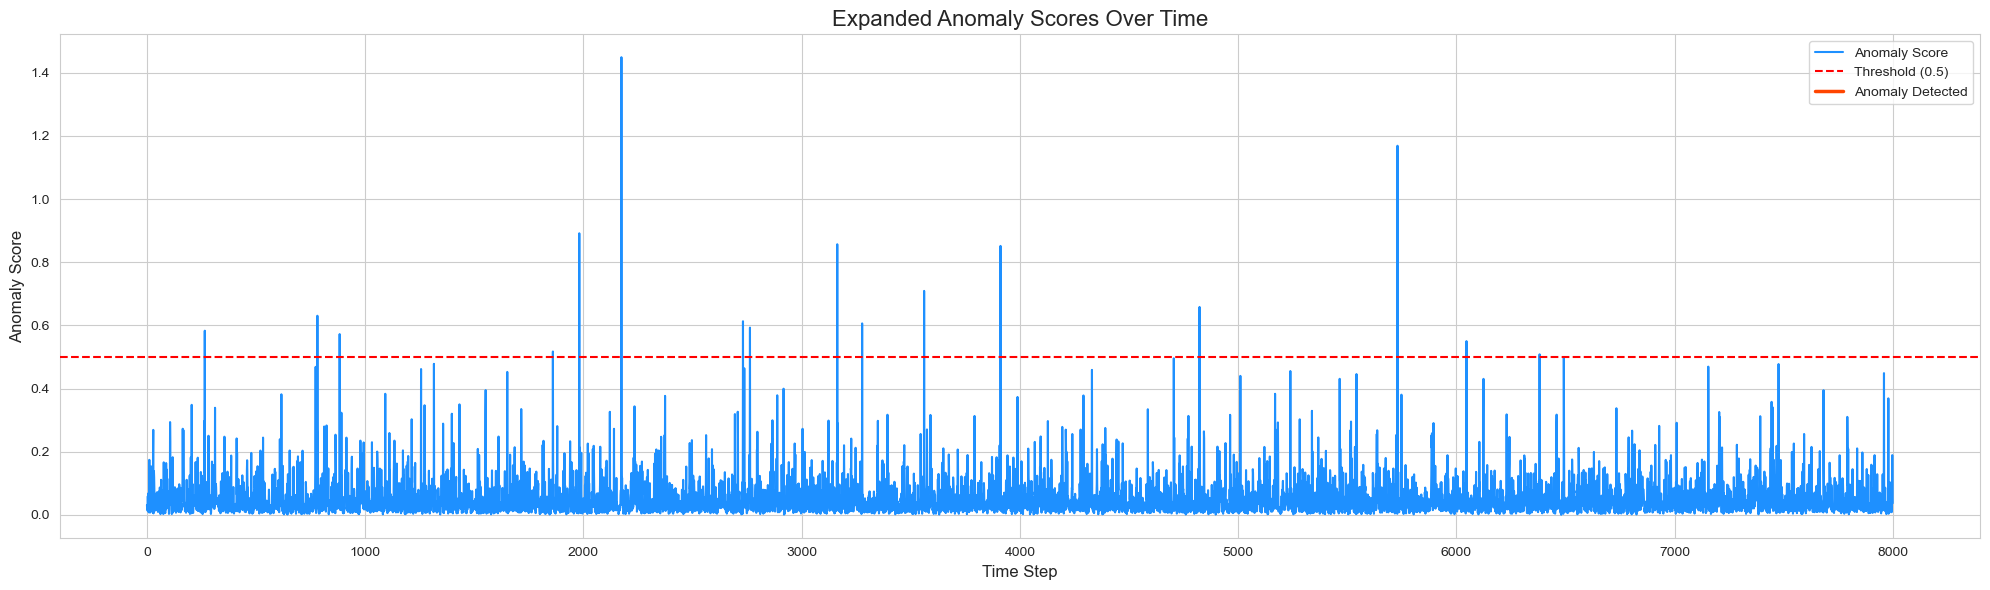

In [11]:
visualize_expanded_scores(anomaly_scores, 8000, 100, 100, threshold=0.5)